<h1 style="font-size: 25px; color: #FFD1DC; font-weight: bold;">Исследовательский мини-проект "Аудитория English-сообществ ВК"</h1>

<b>Автор:</b> Тхамокова Сабина БМД239

#### <b>Введение<b>
В данном исследовательском мини-проекте проведен анализ социально-демографических характеристик подписчиков пяти крупных сообществ по изучению английского языка в социальной сети ВКонтакте. Цель исследования — выявить особенности аудитории таких сообществ и получить инсайты о том, кто интересуется изучением английского языка онлайн.

#### <b>Источники данных<b>
Данные получены через API ВКонтакте. Для исследования выбраны 5 популярных сообществ:
- Skillbox
- Фоксфорд
- Яндекс Практикум
- Skyeng
- Инглекс

Доступ к данным осуществлялся с использованием официального API ВКонтакте, что соответствует правилам использования платформы.

In [1]:
# загружаем необходимые библиотеки

import datetime                  # пакет для работы с временными форматами
import pickle                    # пакет для подгрузки данных специфического для питона формата
import requests                  # пакет для скачки данных из этих ваших интернетов
import pandas as pd              # пакет для работы с таблицами
import numpy as np               # пакет для работы с векторами и матрицами
import matplotlib.pyplot as plt  # пакет для строительства графиков
import time            # пакет для работы со временем. Например, помогает ставить заглушки 
                       # time.sleep(секунды), необходимые для того что ВК не банил нащего
                       # сборщика данных из-за слишком частых запросов
        
from tqdm import tqdm_notebook # пакет для красивых циклов

#### <b>Методология сбора данных<b>

В рамках проекта были использованы следующие шаги для сбора и обработки данных:

1. Подключение к API ВКонтакте с использованием персонального токена доступа
2. Получение списка участников каждого сообщества
3. Получение подробной информации о пользователях, включая демографические данные
4. Объединение данных в единый датафрейм для анализа
5. Преобразование данных для последующего анализа

#### <b>Основные инструменты<b>
- Python (pandas, numpy, matplotlib, requests)
- API ВКонтакте (версия 5.103)
- Jupyter Notebook для документирования процесса и анализа

#### <b>Подключение к API ВКонтакте<b>

In [2]:
# версия используемого API
version = '5.103' 
# подгружаем токен
with open('C:/Users/user/Downloads/API/token.txt') as f:
    token = f.read()

Функция <b>vkDownload</b> используется для выполнения запросов к API ВКонтакте. Она принимает название метода, параметры запроса, токен и версию API, формирует URL запроса и возвращает ответ в формате JSON.

In [32]:
def vkDownload(method, parameters, token=token, version=version):
    """
        Возвращает результат запроса по методу
        
        method: string
            метод из документации, который хотим использовать
            
        parameters: string
            параметры используемого метода
            
        token: string
            токен Oauth доступа
        
        version: string
            версия API
    """
    
    # составляем ссылку
    url = 'https://api.vk.com/method/{method}?{parameters}&access_token={token}&v={version}'
    url = url.format(method=method, parameters=parameters, token=token, version=version)
    # запрашиваем ссылку и переводим в json (словарь)
    response = requests.get(url).json()
    
    return response

<h2 style="color: #FFD1DC; font-size: 20px;"><strong>Cоциально-демографические признаки</strong></h2>

#### <b>Определение запрашиваемых данных<b>

In [110]:
 # основные параметры, которые хотим получить
fields = 'bdate, city, home_town, sex, education'

#### <b>Выбор источников данных</b>

Для исследования выбраны 5 крупных образовательных платформ, имеющих сообщества ВКонтакте:
1. **Skillbox** - образовательная платформа с курсами по различным направлениям
2. **Фоксфорд** - онлайн-школа для учеников 1−11 классов
3. **Яндекс Практикум** - образовательный проект от Яндекса
4. **Skyeng** - онлайн-школа английского языка
5. **Инглекс** - сервис изучения английского языка

Создаем словарь <b>english_groups</b>, где ключами являются названия сообществ по изучению английского, а значениями — их идентификаторы.

In [36]:
english_groups = {
     'Skillbox' : '202176591',
     'Фоксфорд' : '21092922',
     'Яндекс Практикум' : '192853575',
     'Skyeng' : '51890028',
     'Инглекс' : '49709122'
    }

#### <b>Сбор и сохранение данных о подписчиках</b>

Функция <b>getGroupMembers</b> используется для получения списка всех пользователей заданной группы. Она определяет необходимое количество запросов (по 1000 пользователей за раз), выполняет их с помощью метода <b>groups.getMembers</b>, собирает полученные идентификаторы пользователей в единый список members и возвращает его. Между запросами добавлена пауза в 0.4 секунды во избежание превышения лимитов API.

In [34]:
def getGroupMembers(group_id):
    """
        Возвращает список всех пользователей данной группы
        Итерации идут батчами по 1000 пользователей
        
        group_id: string
            идентификатор группы (ссылка)
    """
    
    # узнаём число запросов, которое надо сделать 
    count = vkDownload('groups.getMembers','group_id=' + group_id)['response']['count']
    
    # выясняем, сколько запросов нам понадобиться
    n = int(np.ceil(count/1000))  
    
    # вектор, где мы будем хранить id пользователей
    members = []     
    
    for i in tqdm_notebook(range(n)): 
        # при помощи метода groups.getMembers получаем пользователей группы
        current_members = vkDownload('groups.getMembers','group_id='+group_id+'&offset='+str(1000*i))
        members.extend(current_members['response']['items'])
        # перед следующим запросом немножко подождем
        time.sleep(0.4)
        
    return members

Далее проходимся по всем сообществам из словаря <b>english_groups</b>, получаем список их участников с помощью функции <b>getGroupMembers</b> и сохраняем результаты в словарь <b>english_people</b>, где ключами являются названия сообществ, а значениями — списки с идентификаторами пользователей. Сохраняем полученный словарь в файл 'english_people' с помощью модуля pickle.

In [37]:
# цикл для выгрузки всех участников групп
# выкачиваем членов каждой группы 

english_people = {}
for english, group_id in english_groups.items():
    english_people[english] = getGroupMembers(group_id)

# сохраняем словарик с id пользователей
with open('english_people', 'wb') as f:
    pickle.dump(english_people, f)

C:\Users\user\AppData\Local\Temp\ipykernel_5216\671095236.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Выводим информацию о количестве подписчиков в каждом сообществе.

In [107]:
for english, people in english_people.items():
    print("Группа курса по английскому: {}, число подписчиков: {}".format(english, len(people)))

Группа курса по английскому: Skillbox, число подписчиков: 5808
Группа курса по английскому: Фоксфорд, число подписчиков: 271480
Группа курса по английскому: Яндекс Практикум, число подписчиков: 6795
Группа курса по английскому: Skyeng, число подписчиков: 211434
Группа курса по английскому: Инглекс, число подписчиков: 56671


Функция <b>getUserInformation</b> используется для получения детальной информации (указанной в переменной <b>fields</b>) о каждом пользователе из ранее полученных списков. Запросы выполняются порциями по 500 пользователей через метод <b>users.get</b>. Полученная информация сохраняется в словарь <b>english_people_information</b>, где ключами являются названия сообществ, а значениями — списки с данными о пользователях. Между запросами также добавлена пауза в 0.4 секунды.

In [42]:
def getUserInformation():
    """
        Возвращает словарь с выгруженными социально-демографическими данными 
        по всем пользователям, подписанным на группы
    """
    
    # инициализируем пустой словарь, где будут хранитсья пользователи с их соцдемом
    english_people_information = {}
    # проходимся по всем кандидатам
    for english, people in english_people.items():
        # текущий список пользователей с соц-демом
        current_info = []
        #посчитаем число пользователей для группы
        count = len(people)
        # Выяснили число запросов
        n = int(np.ceil(count/500))  
        
        for i in tqdm_notebook(range(n)):
            # берем текущий срез подписчиков
            ids = people[i*500:(i+1)*500]
            ids = ','.join([str(user) for user in ids])
            # выгружаем их и берем данные
            info = vkDownload('users.get','user_ids={}&fields={}'.format(ids, fields))
            info = info['response']
            # записываем в текущий лист
            current_info.extend(info)
            # ждем перед следующим запросом
            time.sleep(0.4)
        
        # записываем в финальный словарь
        english_people_information[english] = current_info
    
    return english_people_information

In [43]:
english_people_information = getUserInformation()

C:\Users\user\AppData\Local\Temp\ipykernel_5216\2527131233.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

In [44]:
#спрячем данные в дамп pickle
with open('english_people_information', 'wb') as f:
     pickle.dump(english_people_information, f)

Создаем пустой датафрейм <b>people_information_df</b>, затем проходимся по словарю <b>english_people_information</b>, преобразуем данные о подписчиках каждой группы в отдельный датафрейм <b>df</b>, добавляем в него столбцы с названием города (извлекая его из вложенного словаря) и названием группы. Затем объединяем полученные датафреймы в один общий — <b>people_information_df</b>.

In [46]:
# инициализируем датафрейм
people_information_df = pd.DataFrame()

# идем по всем кандидатам и соц-сети их подписчиков
for english, people in english_people_information.items():
    # преобразуем в словарь в датафрейм
    df = pd.DataFrame(people)
    # добавляем столбец с городом
    df['city'] = df.city.apply(lambda x: x['title'] if x is not np.nan else np.nan)
    # добавляем столбец с городом
    df['university'] = english
    # добавляем преобразованный датафрейм к финальному
    people_information_df = pd.concat([people_information_df, df], ignore_index=True)

In [47]:
people_information_df

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,university_name,faculty,faculty_name,graduation,home_town,education_form,education_status
0,41111,31.3.1983,Ростов-на-Дону,1,Мария,Дьяченко,False,True,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83679,18.4,Санкт-Петербург,1,Оля,Бачурина,True,False,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,121510,NaN,Москва,1,Алёна,Крашенинникова,False,True,banned,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,137024,30.9,Москва,1,Дарья,Кузнецова,True,False,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,218477,13.8.1966,Санкт-Петербург,2,Евгений,Шупяцкий,True,False,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552183,1033045071,6.7.1992,NaN,1,Анна,Шин,True,False,NaN,Инглекс,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552184,1033134461,NaN,NaN,2,Test,Test,False,True,NaN,Инглекс,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552185,1033622598,13.6.1983,NaN,1,Зоя,Корнева,True,False,NaN,Инглекс,,0.0,,0.0,,NaN,NaN
552186,1034731979,NaN,NaN,1,Zhansaya,Bekenkhanova,False,True,NaN,Инглекс,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <b>Преобразование данных<b>

Преобразуем числовые обозначения пола (1, 2) в текстовые ('Female', 'Male').

In [48]:
people_information_df['sex'] = people_information_df['sex'].map({1:'Female',2:'Male'})

In [49]:
people_information_df

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,university_name,faculty,faculty_name,graduation,home_town,education_form,education_status
0,41111,31.3.1983,Ростов-на-Дону,Female,Мария,Дьяченко,False,True,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83679,18.4,Санкт-Петербург,Female,Оля,Бачурина,True,False,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,121510,NaN,Москва,Female,Алёна,Крашенинникова,False,True,banned,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,137024,30.9,Москва,Female,Дарья,Кузнецова,True,False,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,218477,13.8.1966,Санкт-Петербург,Male,Евгений,Шупяцкий,True,False,NaN,Skillbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552183,1033045071,6.7.1992,NaN,Female,Анна,Шин,True,False,NaN,Инглекс,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552184,1033134461,NaN,NaN,Male,Test,Test,False,True,NaN,Инглекс,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552185,1033622598,13.6.1983,NaN,Female,Зоя,Корнева,True,False,NaN,Инглекс,,0.0,,0.0,,NaN,NaN
552186,1034731979,NaN,NaN,Female,Zhansaya,Bekenkhanova,False,True,NaN,Инглекс,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <b>Добавление признака возраста пользователя по дате рождения<b>

In [56]:
df_bdate = people_information_df
# датафрейм df_ нужен для временного хранения данных о дате рождения в разных столбцах
df_ = df_bdate['bdate'].str.split('.', expand=True)
# объединяем два датарфрейиа по index
df_bdate = pd.concat([df_bdate, df_], axis=1)
df_bdate = df_bdate.rename(columns={0: 'day_bdate', 1: 'month_bdate', 2: 'year_bdate'})
# удаляем столбцы с днем и месяцем рождения, нам нужен только год
df_bdate['year_bdate'] = pd.to_numeric(df_bdate['year_bdate'], errors= 'coerce')
df_bdate['age'] = 2024 - df_bdate['year_bdate']
df_bdate

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,...,faculty,faculty_name,graduation,home_town,education_form,education_status,day_bdate,month_bdate,year_bdate,age
0,41111,31.3.1983,Ростов-на-Дону,Female,Мария,Дьяченко,False,True,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,31,3,1983.0,41.0
1,83679,18.4,Санкт-Петербург,Female,Оля,Бачурина,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,18,4,NaN,NaN
2,121510,NaN,Москва,Female,Алёна,Крашенинникова,False,True,banned,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,137024,30.9,Москва,Female,Дарья,Кузнецова,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,30,9,NaN,NaN
4,218477,13.8.1966,Санкт-Петербург,Male,Евгений,Шупяцкий,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,13,8,1966.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552183,1033045071,6.7.1992,NaN,Female,Анна,Шин,True,False,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,6,7,1992.0,32.0
552184,1033134461,NaN,NaN,Male,Test,Test,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552185,1033622598,13.6.1983,NaN,Female,Зоя,Корнева,True,False,NaN,Инглекс,...,0.0,,0.0,,NaN,NaN,13,6,1983.0,41.0
552186,1034731979,NaN,NaN,Female,Zhansaya,Bekenkhanova,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <b>Добавление признака поколения<b>

In [58]:
def get_generation_by_age(age):
    if pd.isna(age):
        return "Неизвестно"
    elif age >= 60:  
        return "Бумеры и старше"
    elif age >= 45:  
        return "Поколение X"
    elif age >= 28:  
        return "Миллениалы"
    elif age >= 16:  
        return "Поколение Z"
    else:
        return "Поколение Alpha"  
    
df_bdate['generation'] = df_bdate['age'].apply(get_generation_by_age)
df_bdate

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,...,faculty_name,graduation,home_town,education_form,education_status,day_bdate,month_bdate,year_bdate,age,generation
0,41111,31.3.1983,Ростов-на-Дону,Female,Мария,Дьяченко,False,True,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,31,3,1983.0,41.0,Миллениалы
1,83679,18.4,Санкт-Петербург,Female,Оля,Бачурина,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,18,4,NaN,NaN,Неизвестно
2,121510,NaN,Москва,Female,Алёна,Крашенинникова,False,True,banned,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно
3,137024,30.9,Москва,Female,Дарья,Кузнецова,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,30,9,NaN,NaN,Неизвестно
4,218477,13.8.1966,Санкт-Петербург,Male,Евгений,Шупяцкий,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,NaN,13,8,1966.0,58.0,Поколение X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552183,1033045071,6.7.1992,NaN,Female,Анна,Шин,True,False,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,6,7,1992.0,32.0,Миллениалы
552184,1033134461,NaN,NaN,Male,Test,Test,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно
552185,1033622598,13.6.1983,NaN,Female,Зоя,Корнева,True,False,NaN,Инглекс,...,,0.0,,NaN,NaN,13,6,1983.0,41.0,Миллениалы
552186,1034731979,NaN,NaN,Female,Zhansaya,Bekenkhanova,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно


#### <b>Добавление признака сезона рождения<b>

In [60]:
def get_season(month):
    if pd.isna(month):
        return "Неизвестно"
    elif month in ['12', '1', '2']:
        return "Зима"
    elif month in ['3', '4', '5']:
        return "Весна"
    elif month in ['6', '7', '8']:
        return "Лето"
    else:
        return "Осень"
    
df_bdate['birth_season'] = df_bdate['month_bdate'].apply(get_season)
df_bdate

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,...,graduation,home_town,education_form,education_status,day_bdate,month_bdate,year_bdate,age,generation,birth_season
0,41111,31.3.1983,Ростов-на-Дону,Female,Мария,Дьяченко,False,True,NaN,Skillbox,...,NaN,NaN,NaN,NaN,31,3,1983.0,41.0,Миллениалы,Весна
1,83679,18.4,Санкт-Петербург,Female,Оля,Бачурина,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,18,4,NaN,NaN,Неизвестно,Весна
2,121510,NaN,Москва,Female,Алёна,Крашенинникова,False,True,banned,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно,Неизвестно
3,137024,30.9,Москва,Female,Дарья,Кузнецова,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,30,9,NaN,NaN,Неизвестно,Осень
4,218477,13.8.1966,Санкт-Петербург,Male,Евгений,Шупяцкий,True,False,NaN,Skillbox,...,NaN,NaN,NaN,NaN,13,8,1966.0,58.0,Поколение X,Лето
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552183,1033045071,6.7.1992,NaN,Female,Анна,Шин,True,False,NaN,Инглекс,...,NaN,NaN,NaN,NaN,6,7,1992.0,32.0,Миллениалы,Лето
552184,1033134461,NaN,NaN,Male,Test,Test,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно,Неизвестно
552185,1033622598,13.6.1983,NaN,Female,Зоя,Корнева,True,False,NaN,Инглекс,...,0.0,,NaN,NaN,13,6,1983.0,41.0,Миллениалы,Лето
552186,1034731979,NaN,NaN,Female,Zhansaya,Bekenkhanova,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно,Неизвестно


#### <b>Добавление признака активности пользователя<b>

In [67]:
# создаем словарь для хранения членства в сообществах
user_memberships = {}

# проходим по всем сообществам
for english, group_id in english_groups.items():
    # получаем список пользователей в этом сообществе
    members = getGroupMembers(group_id)
    
    # добавляем информацию о членстве для каждого пользователя
    for member_id in members:
        if member_id not in user_memberships:
            user_memberships[member_id] = []
        user_memberships[member_id].append(english)

# функция для определения активности пользователей
def is_active_user(user_id):
    # если пользователя нет в словаре или он состоит только в одном сообществе - неактивный
    if user_id not in user_memberships or len(user_memberships[user_id]) <= 1:
        return "Неактивный"
    else:
        # если состоит более чем в одном сообществе - активный
        return "Активный"
        
df_bdate['activity_status'] = df_bdate['id'].apply(is_active_user)

C:\Users\user\AppData\Local\Temp\ipykernel_5216\671095236.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [68]:
df_bdate

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,...,education_form,education_status,day_bdate,month_bdate,year_bdate,age,generation,birth_season,city_category,activity_status
0,41111,31.3.1983,Ростов-на-Дону,Female,Мария,Дьяченко,False,True,NaN,Skillbox,...,NaN,NaN,31,3,1983.0,41.0,Миллениалы,Весна,Крупный город,Неактивный
1,83679,18.4,Санкт-Петербург,Female,Оля,Бачурина,True,False,NaN,Skillbox,...,NaN,NaN,18,4,NaN,NaN,Неизвестно,Весна,Крупный город,Неактивный
2,121510,NaN,Москва,Female,Алёна,Крашенинникова,False,True,banned,Skillbox,...,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно,Неизвестно,Крупный город,Неактивный
3,137024,30.9,Москва,Female,Дарья,Кузнецова,True,False,NaN,Skillbox,...,NaN,NaN,30,9,NaN,NaN,Неизвестно,Осень,Крупный город,Активный
4,218477,13.8.1966,Санкт-Петербург,Male,Евгений,Шупяцкий,True,False,NaN,Skillbox,...,NaN,NaN,13,8,1966.0,58.0,Поколение X,Лето,Крупный город,Неактивный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552183,1033045071,6.7.1992,NaN,Female,Анна,Шин,True,False,NaN,Инглекс,...,NaN,NaN,6,7,1992.0,32.0,Миллениалы,Лето,Неизвестно,Неактивный
552184,1033134461,NaN,NaN,Male,Test,Test,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно,Неизвестно,Неизвестно,Неактивный
552185,1033622598,13.6.1983,NaN,Female,Зоя,Корнева,True,False,NaN,Инглекс,...,NaN,NaN,13,6,1983.0,41.0,Миллениалы,Лето,Неизвестно,Неактивный
552186,1034731979,NaN,NaN,Female,Zhansaya,Bekenkhanova,False,True,NaN,Инглекс,...,NaN,NaN,NaN,NaN,NaN,NaN,Неизвестно,Неизвестно,Неизвестно,Неактивный


#### <b>Фильтрация и сортировка<b>

In [139]:
# фильтрация пользователей с активным статусом
filtered_df = df_bdate[df_bdate['activity_status'] == 'Активный']

# сортировка по возрасту (по возрастанию)
sorted_df = filtered_df.sort_values(by='age', ascending=True)

# вывод первых 5 строк отфильтрованных и отсортированных данных
sorted_df.head()

,id,bdate,city,sex,first_name,last_name,can_access_closed,is_closed,deactivated,university,...,education_form,education_status,day_bdate,month_bdate,year_bdate,age,generation,birth_season,city_category,activity_status
537467,403103059,4.2.2011,NaN,Female,Мелас,Холе,False,True,NaN,Инглекс,...,NaN,NaN,4,2,2011.0,13.0,Поколение Alpha,Зима,Неизвестно,Активный
432468,342576849,18.1.2011,NaN,Female,Маша,Мишкина,True,False,NaN,Skyeng,...,NaN,NaN,18,1,2011.0,13.0,Поколение Alpha,Зима,Неизвестно,Активный
534518,342576849,18.1.2011,NaN,Female,Маша,Мишкина,True,False,NaN,Инглекс,...,NaN,NaN,18,1,2011.0,13.0,Поколение Alpha,Зима,Неизвестно,Активный
444841,403103059,4.2.2011,NaN,Female,Мелас,Холе,False,True,NaN,Skyeng,...,NaN,NaN,4,2,2011.0,13.0,Поколение Alpha,Зима,Неизвестно,Активный
278449,21108144,14.8.2010,Санкт-Петербург,Female,Valentina,Berezhnaya-Multanova,True,False,NaN,Яндекс Практикум,...,NaN,NaN,14,8,2010.0,14.0,Поколение Alpha,Лето,Крупный город,Активный


<h2 style="color: #FFD1DC; font-size: 20px;"><strong>Разведочный анализ данных (EDA)</strong></h2>

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter

#### <b>Общая статистика<b>

In [130]:
print("Общее количество пользователей:", len(df_bdate))

Общее количество пользователей: 552188


#### <b>Анализ пропущенных значений<b>

In [146]:
missing_values = df_bdate.isnull().sum()
print("\nКоличество пропущенных значений по столбцам:")
missing_values


Количество пропущенных значений по столбцам:


id                        0
bdate                127917
city                 185650
sex                     128
first_name                0
last_name                 0
can_access_closed         0
is_closed                 0
deactivated          527271
university                0
university_name      373934
faculty              373934
faculty_name         373934
graduation           373934
home_town            373934
education_form       515239
education_status     519396
day_bdate            127917
month_bdate          127917
year_bdate           331343
age                  331343
generation                0
birth_season              0
city_category             0
activity_status           0
dtype: int64

#### <b>Распределение пользователей по сообществам<b>

In [147]:
university_counts = df_bdate['university'].value_counts()
print("\nРаспределение пользователей по сообществам:")
university_counts


Распределение пользователей по сообществам:


university
Фоксфорд            271480
Skyeng              211434
Инглекс              56671
Яндекс Практикум      6795
Skillbox              5808
Name: count, dtype: int64

#### <b>Распределение по полу<b>

In [148]:
sex_counts = df_bdate['sex'].value_counts()
print("\nРаспределение пользователей по полу:")
sex_counts


Распределение пользователей по полу:


sex
Female    396607
Male      155453
Name: count, dtype: int64

#### <b>Распределение по поколениям<b>

In [149]:
generation_counts = df_bdate['generation'].value_counts()
print("\nРаспределение по поколениям:")
generation_counts


Распределение по поколениям:


generation
Неизвестно         331343
Поколение Z        105668
Миллениалы          73527
Поколение X         25767
Бумеры и старше     13435
Поколение Alpha      2448
Name: count, dtype: int64

#### <b>Распределение по сезону рождения<b>

In [150]:
season_counts = df_bdate['birth_season'].value_counts()
print("\nРаспределение по сезону рождения:")
season_counts


Распределение по сезону рождения:


birth_season
Неизвестно    127917
Лето          111169
Весна         108814
Зима          104683
Осень          99605
Name: count, dtype: int64

#### <b>Распределение по активности<b>

In [151]:
activity_counts = df_bdate['activity_status'].value_counts()
print("\nРаспределение по активности:")
activity_counts


Распределение по активности:


activity_status
Неактивный    518503
Активный       33685
Name: count, dtype: int64

#### <b>Распределение по городам<b>

In [152]:
city_counts = df_bdate['city'].value_counts().head(10)
print("\nТоп-10 городов по количеству пользователей:")
city_counts


Топ-10 городов по количеству пользователей:


city
Москва             58582
Санкт-Петербург    36325
Екатеринбург        7423
Новосибирск         5994
Нижний Новгород     5866
Казань              5631
Краснодар           5254
Самара              5236
Пермь               4986
Уфа                 4750
Name: count, dtype: int64

#### <b>Сравнительный анализ аудиторий сообществ</b>

<Figure size 400x400 with 0 Axes>

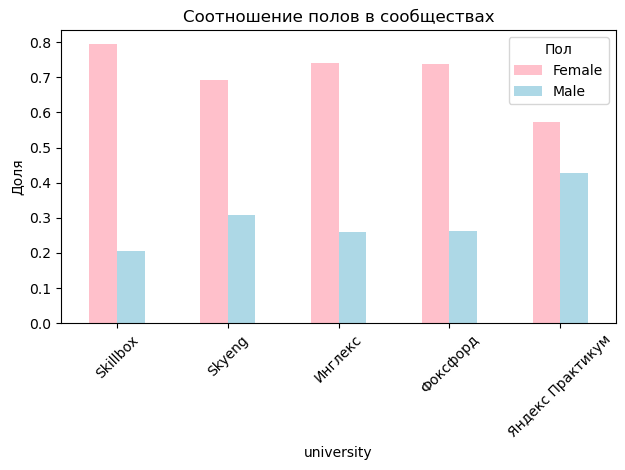

In [166]:
# сравнение полов между сообществами
plt.figure(figsize=(4, 4))
sex_by_community = pd.crosstab(df_bdate['university'], df_bdate['sex'], normalize='index')
sex_by_community.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Соотношение полов в сообществах')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

#### <b>Выводы</b>

Исследование аудитории пяти образовательных платформ ВКонтакте раскрывает тенденции в сфере онлайн-образования, особенно в сегменте изучения английского языка. 
- Существенное преобладание женской аудитории указывает на гендерный дисбаланс в интересе к языковому образованию.
- Значительную часть аудитории составляют представители поколений Z и миллениалы, что подтверждает высокий интерес к онлайн-образованию среди молодежи.
- Географическое распределение пользователей показывает концентрацию в крупных мегаполисах, и это может быть связано с более высоким уровнем цифровизации в этих регионах.
- Низкий уровень кросс-платформенной активности свидетельствует о высокой лояльности к выбранным образовательным платформам.

<h2 style="color: #FFD1DC; font-size: 20px;"><strong>Создание сводных таблиц и группировок</strong></h2>

#### <b>Группировка по сообществам и полу<b>

In [153]:
community_sex_grouped = pd.crosstab(df_bdate['university'], df_bdate['sex'], normalize='index')
print("\nРаспределение пола пользователей по сообществам (%):")
community_sex_grouped * 100 # доли в проценты преобразовываются


Распределение пола пользователей по сообществам (%):


sex,Female,Male
university,,
Skillbox,79.383396,20.616604
Skyeng,69.171815,30.828185
Инглекс,74.068386,25.931614
Фоксфорд,73.657588,26.342412
Яндекс Практикум,57.315278,42.684722


#### <b>Средний возраст по сообществам<b>

In [154]:
age_by_community = df_bdate.groupby('university')['age'].agg(['mean', 'median', 'count']).sort_values(by='mean')
print("\nСредний и медианный возраст по сообществам:")
age_by_community


Средний и медианный возраст по сообществам:


,mean,median,count
university,,,
Skillbox,30.129757,28.0,4362
Фоксфорд,31.763677,24.0,110349
Яндекс Практикум,32.439335,29.0,2588
Инглекс,33.545851,30.0,21559
Skyeng,35.421799,31.0,81987


#### <b>Распределение поколений по сообществам<b>

In [155]:
generation_by_community = pd.crosstab(df_bdate['university'], df_bdate['generation'], normalize='index')
print("\nРаспределение поколений по сообществам (%):")
generation_by_community * 100


Распределение поколений по сообществам (%):


generation,Бумеры и старше,Миллениалы,Неизвестно,Поколение Alpha,Поколение X,Поколение Z
university,,,,,,
Skillbox,1.256887,35.244490,24.896694,0.413223,3.822314,34.366391
Skyeng,2.701552,16.262758,61.223360,0.203846,4.994466,14.614017
Инглекс,1.942793,15.747031,61.957615,0.342327,4.072630,15.937605
Фоксфорд,2.385443,9.945484,59.352807,0.658612,4.596655,23.060999
Яндекс Практикум,1.074319,17.233260,61.913171,0.161884,2.913907,16.703458


#### <b>Распределение по сезону рождения и сообществам<b>

In [156]:
season_by_community = pd.crosstab(df_bdate['university'], df_bdate['birth_season'], normalize='index')
print("\nРаспределение сезона рождения по сообществам (%):")
season_by_community * 100


Распределение сезона рождения по сообществам (%):


birth_season,Весна,Зима,Лето,Неизвестно,Осень
university,,,,,
Skillbox,24.053030,21.918044,22.658402,11.002066,20.368457
Skyeng,19.178089,18.557091,19.509634,25.195569,17.559617
Инглекс,18.406240,18.079794,19.473805,27.019110,17.021051
Фоксфорд,20.319361,19.384485,20.709445,20.979814,18.606896
Яндекс Практикум,18.749080,19.175865,19.793966,25.577631,16.703458


#### <b>Средний возраст пользователей по полу<b>

In [157]:
age_by_gender = df_bdate.groupby('sex')['age'].agg(['mean', 'median'])
print("\nСтатистика возраста по полу:")
age_by_gender


Статистика возраста по полу:


,mean,median
sex,,
Female,33.605096,28.0
Male,32.555592,27.0


<h2 style="color: #FFD1DC; font-size: 20px;"><strong>Визуализация</strong></h2>

#### <b>Бар-чарт "Распределение пользователей по университетам"<b>

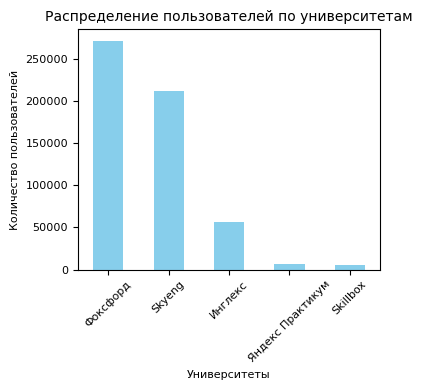

In [121]:
# подсчет количества пользователей по сообществам 
user_counts = df_bdate['university'].value_counts()

# построение бар-чарта
plt.figure(figsize=(4, 4))
user_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение пользователей по университетам', fontsize=10)  
plt.xlabel('Университеты', fontsize=8)  
plt.ylabel('Количество пользователей', fontsize=8)  
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

#### <b>Линейный график "Средний возраст пользователей по сообществам"<b>

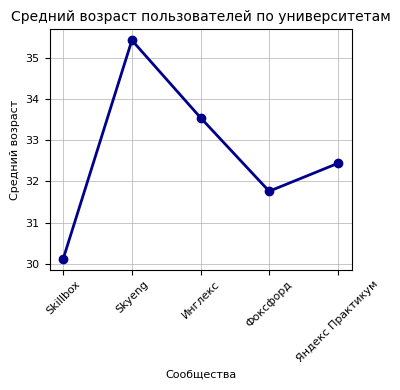

In [118]:
age_by_community = df_bdate.groupby('university')['age'].mean()

plt.figure(figsize=(4, 4))
age_by_community.plot(kind='line', marker='o', color='darkblue', linewidth=2)
plt.title('Средний возраст пользователей по университетам', fontsize=10)
plt.xlabel('Сообщества', fontsize=8)
plt.ylabel('Средний возраст', fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(linewidth=0.5)
plt.tight_layout()
plt.show()

#### <b>Круговая диаграмма "Распределение пользователей по активности"<b>

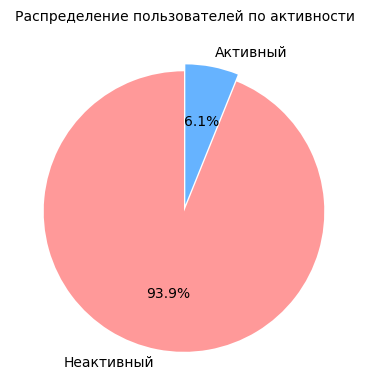

In [128]:
activity_counts = df_bdate['activity_status'].value_counts()

plt.figure(figsize=(4, 4))
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0)
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
plt.title('Распределение пользователей по активности', fontsize=10)
plt.tight_layout()
plt.show()

#### <b>Сохранение полученного датасета с социально-демографическими признаками пользователей в файл (.xlsx)<b>

In [144]:
df_bdate.to_excel('final_df.xlsx', index=False, engine='openpyxl')
print("Файл успешно сохранен")

Exception ignored in: <function ZipFile.__del__ at 0x000002059CE8CAE0>
Traceback (most recent call last):
  File "C:\Users\user\anaconda32\Lib\zipfile\__init__.py", line 1940, in __del__
    self.close()
  File "C:\Users\user\anaconda32\Lib\zipfile\__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Файл успешно сохранен
